# Lab 8: Autoencoders

## Goal of this lab:

1. Understand the architecture of autoendcoders
2. Denoise autoencoder
3. Autoencoder for classification

## Why Autoencoder:

By learning to reconstruct the image, the autoencoder learns the essential features in the low dimension 
space. It can be treated as a pretraining process for getting the good initialization of weights which leads to better performance.

## Architecture:    
<img src="https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png" alt="alt text" width="548" height="435">

- Encoder stage: map an input to a hidden state through an affine transformation 
$$
h= f(W_{h}x + b)
$$
where f is an element-wise activation function. Represent input in an encoded representation.
    
    
- Decoder stage: 
$$    
\hat{x} = g(W_{x}h + b)
$$   
Reconstruct the input as close as the original input.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import  confusion_matrix
import itertools

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# verify that the gpu is recognized by torch
print(device)

cuda:0


## Data

In [4]:
batch_size = 64
# Data Loader
train_loader = DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(torch.tensor([0.5]),torch.tensor([0.5])) # mean 0.5, std 0.5
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('./', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(torch.tensor([0.5]),torch.tensor([0.5]))
                   ])),
    batch_size=batch_size, shuffle=True)

In [5]:
def plot_digits(digits):
    grids = make_grid(digits, nrow=8)
    plt.figure(figsize=(12, 9))
    plt.imshow(grids.numpy()[0], cmap='gray')

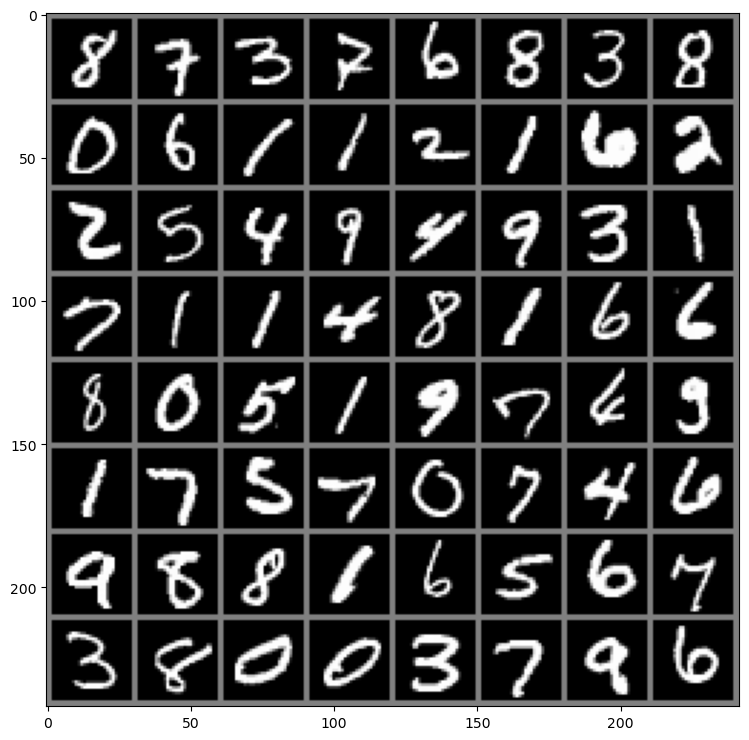

In [6]:
# The next() function returns the next item from the iterator.
data, label = next(iter(train_loader))
plot_digits(data)

## Task: Image Denoising Using Auto-encoder

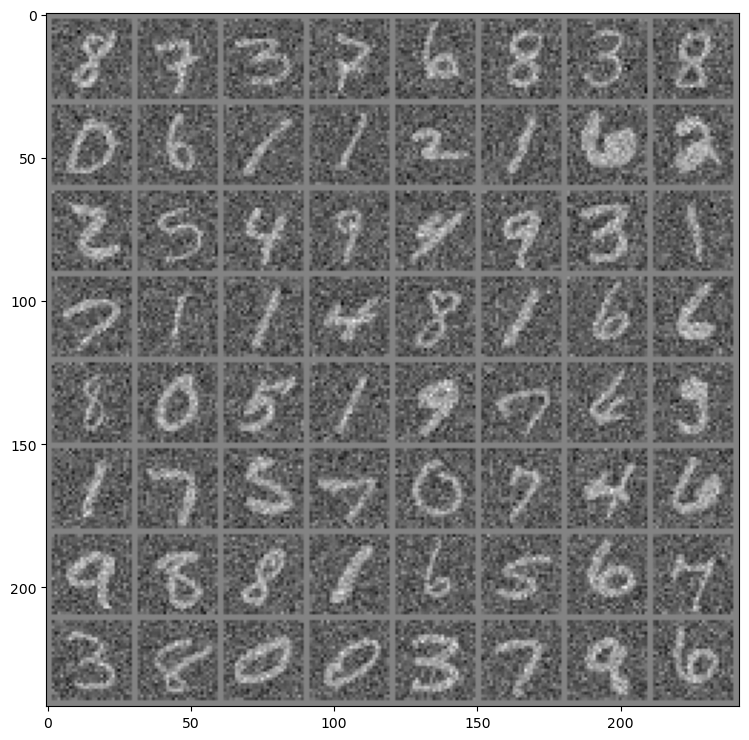

In [7]:
# adding Gaussian noise
plot_digits(data + torch.FloatTensor(data.size()).normal_(mean=0, std=0.6))


<img src="https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png" alt="alt text" width="300" height="120">

A simple version of autoencoder. If you're looking for a more complex architecture, it would probably be better to write separate classes of Encoder and Decoder, then include them both in the model. However, since we're using pretty straightforward MLPs, we can do that in a single class by utilizing the ```nn.Sequential``` module.

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Sigmoid()  # Using sigmoid to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training

Next, we will train our autoencoder to denoise handwritten digit image data. Use the functions below and complete the code where necessary. Think about what kind of loss to use as the reconstruction loss for this task.

In [9]:
def test_model(loader, model, criterion, std=0.6, limit=None):
    """
    Help function that tests the models's performance on a dataset
    :param: loader: data loader for the dataset to test against
    """
    loss = 0
    num_samples = 0
    
    model.eval()
    
    for i, (data, labels) in enumerate(loader):
        if i and i==limit:
            break
        data_noise = data + torch.FloatTensor(data.size()).normal_(std=std)
        outputs = model(data_noise.squeeze().view(-1, 28 * 28).to(device))
        # compute loss
        loss += criterion(outputs, data.view(-1,28*28).to(device)).item() * data.size()[0]
        num_samples += data.size()[0]

    return loss/num_samples

In [10]:
def train(model, loader, criterion, optimizer, num_epochs=40, std=0.6, log_interval=300):
    for epoch in range(num_epochs):
        for i, (data, labels) in enumerate(loader):
            model.train()
            # add gaussian noise to data
            data_noise = data + torch.FloatTensor(data.size()).normal_(std=std)
            
            model.zero_grad()
            outputs = model(data_noise.squeeze().view(-1, 28 * 28).to(device))
            loss = criterion(outputs, data.view(-1,28*28).to(device))
            loss.backward()
            optimizer.step()

             # report performance
            if (i + 1) % log_interval == 0:
                test_loss = test_model(test_loader, model, criterion, std)
                print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train Loss: {4}, Validation Loss:{5}'.format(
                    epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(), test_loss))

In [11]:
learning_rate = 5e-5

model = AutoEncoder().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch: [1/20], Step: [300/938], Train Loss: 0.9229284524917603, Validation Loss:0.9257300678253174
Epoch: [1/20], Step: [600/938], Train Loss: 0.9247714877128601, Validation Loss:0.9247278482437133
Epoch: [1/20], Step: [900/938], Train Loss: 0.922681987285614, Validation Loss:0.9205639974594116
Epoch: [2/20], Step: [300/938], Train Loss: 0.9078510403633118, Validation Loss:0.9131368189811706
Epoch: [2/20], Step: [600/938], Train Loss: 0.9039709568023682, Validation Loss:0.9062522150039672
Epoch: [2/20], Step: [900/938], Train Loss: 0.9006838202476501, Validation Loss:0.8971478841781616
Epoch: [3/20], Step: [300/938], Train Loss: 0.8963808417320251, Validation Loss:0.8905205997467041
Epoch: [3/20], Step: [600/938], Train Loss: 0.8837463855743408, Validation Loss:0.8849157796859741
Epoch: [3/20], Step: [900/938], Train Loss: 0.8791370391845703, Validation Loss:0.8797908106803894
Epoch: [4/20], Step: [300/938], Train Loss: 0.8882942795753479, Validation Loss:0.8754307667732238
Epoch: [4/2

## Visualize Results

Let's take a look at how we can use our trained model:

Text(0.5, 1.0, 'Sampled original data')

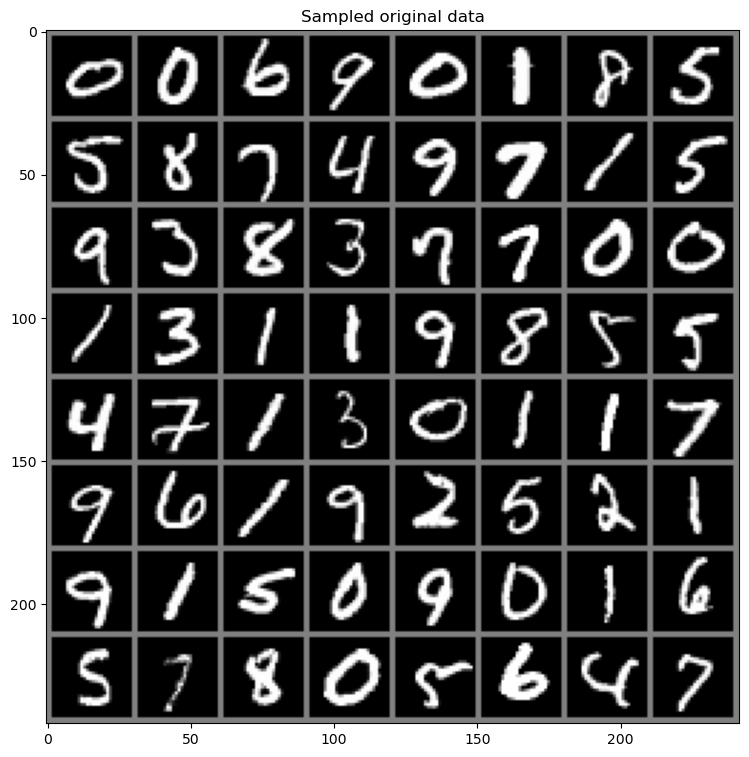

In [12]:
data, label = next(iter(test_loader))
plot_digits(data)
plt.title("Sampled original data")

Text(0.5, 1.0, 'Data with Gaussian noise')

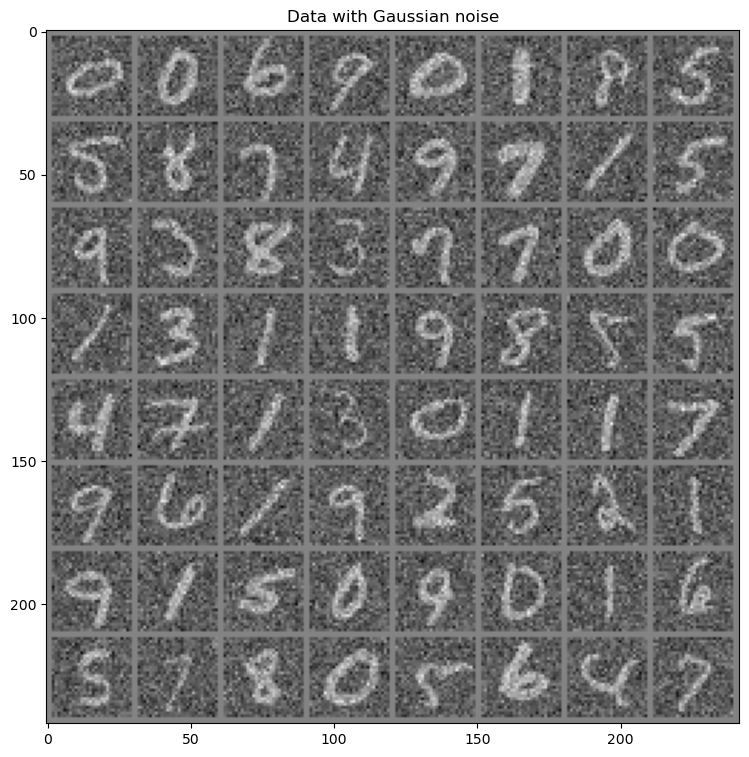

In [13]:
data_noise = data + torch.FloatTensor(data.size()).normal_(mean=0, std=0.6)
plot_digits(data_noise)
plt.title("Data with Gaussian noise")

Text(0.5, 1.0, 'Reconstructed (denoised) images')

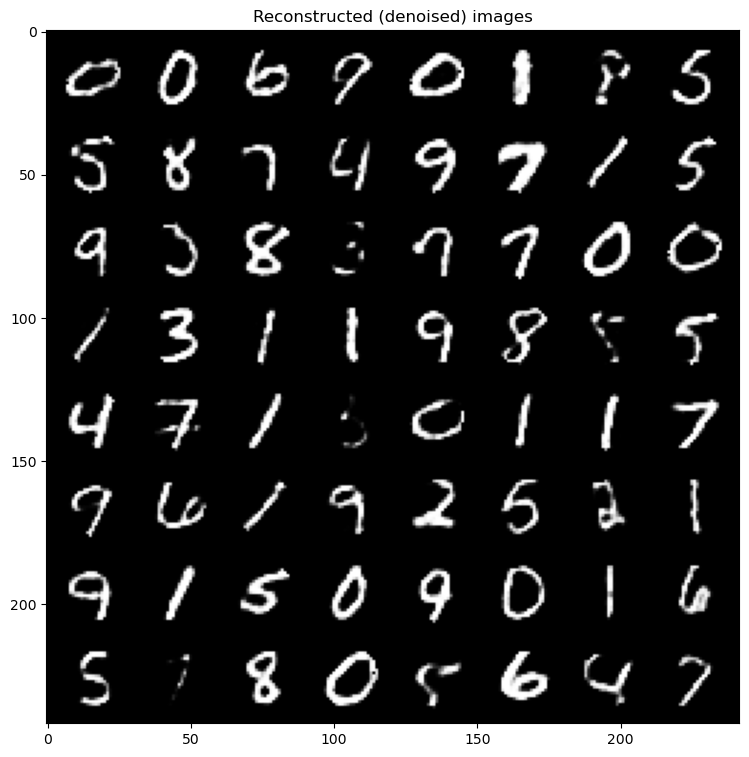

In [14]:
# denoise the data
model.eval()
reconstruction = model(data_noise.view(-1, 28 * 28).to(device))

reconstruction = reconstruction.view(-1, 1, 28, 28).data.cpu()
plot_digits(reconstruction)
plt.title("Reconstructed (denoised) images")

# Visualization of High dimensional vectors using t-SNE

Useful Link to understand t-SNE and how to interpret the visualization: https://distill.pub/2016/misread-tsne/

In [15]:
from sklearn.manifold import TSNE

In [16]:
# a guess about the number of close neighbors each point has
tsne = TSNE(perplexity=50)

In [17]:
data_np = []
y_np = []
encoded_data_np = []
for data in train_loader:
    encoded_data = model.encoder(data[0].view(-1,28*28).to(device)).cpu().detach().numpy()
    encoded_data_np.append(encoded_data)
    data_np.append(data[0].view(-1,28*28).numpy())
    y_np.append(data[1].numpy())
data_np = np.concatenate(data_np, axis = 0)[:2500,:]
y_np = np.concatenate(y_np)[:2500]
encoded_data_np = np.concatenate(encoded_data_np,axis = 0)[:2500,:]

In [18]:
red_data = tsne.fit_transform(data_np)
red_encoded = tsne.fit_transform(encoded_data_np)

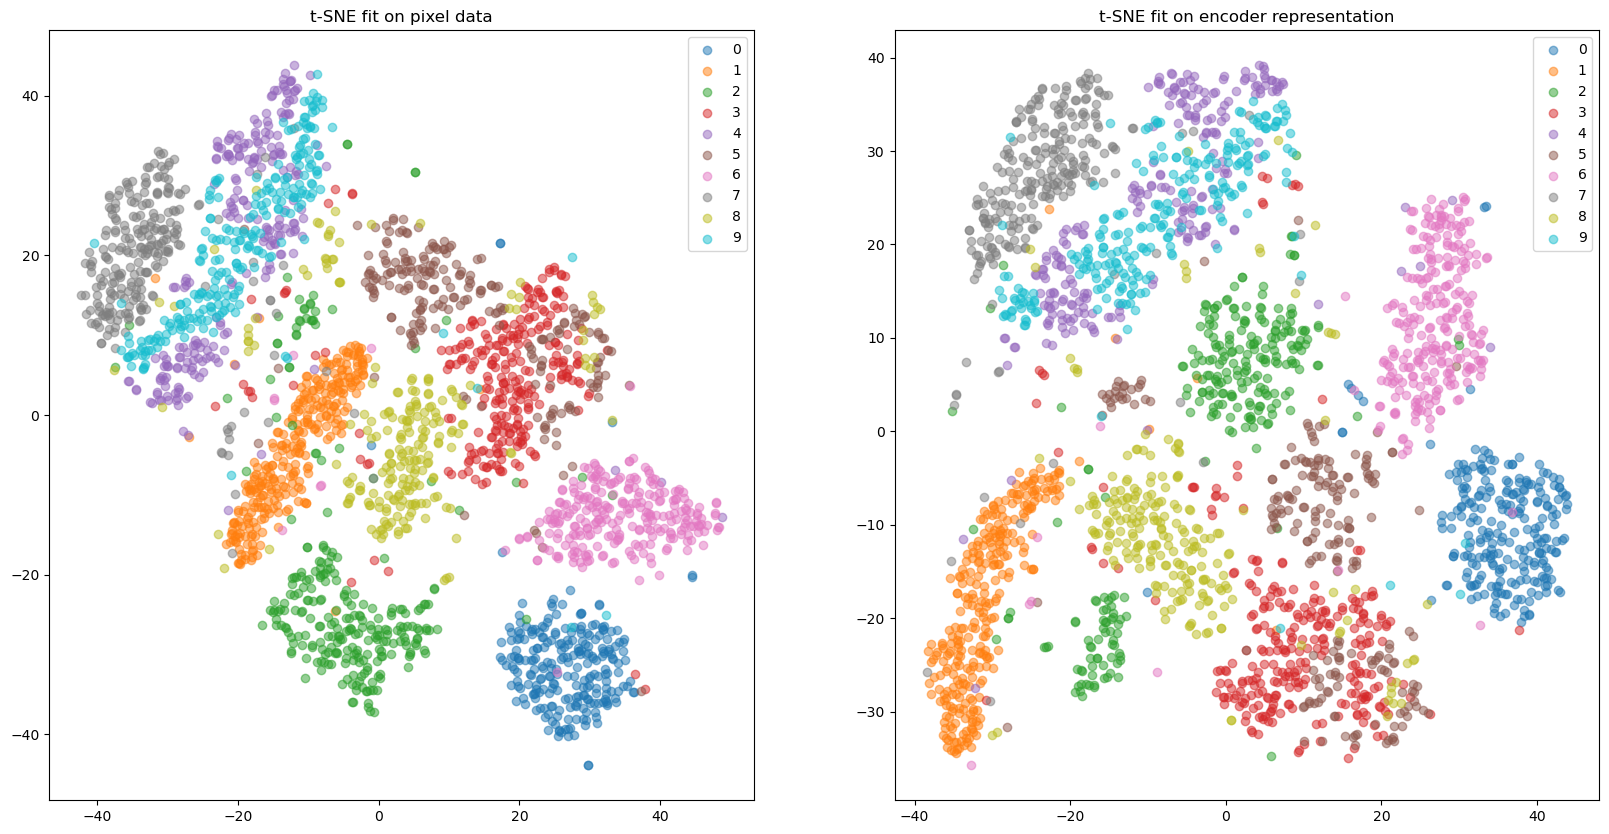

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
for i in range(10):
    ax[0].scatter(red_data[:,0][y_np == i],red_data[:,1][y_np == i], label = str(i), alpha = 0.5)
    ax[1].scatter(red_encoded[:,0][y_np == i],red_encoded[:,1][y_np == i], label = str(i), alpha = 0.5)

ax[0].set_title('t-SNE fit on pixel data')
ax[1].set_title('t-SNE fit on encoder representation')
ax[0].legend()
ax[1].legend()
plt.show()

# Using the encoder for classification

With the representation learned with the autoencoder, we can train a classifier using the pre-trained encoder. 

In [20]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(Classifier, self).__init__()
        self.encoder = encoder
        # Calassification layer
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [21]:
# Remove the decoder part
encoder_for_classification = model.encoder

# Create the classifier model
classifier = Classifier(encoder=encoder_for_classification)

# We freeze the weights of the encoders
for param in classifier.encoder.parameters():
    param.requires_grad = False
    
# Move the model to the appropriate device (CPU or GPU)
classifier.to(device)

# Define your loss function and optimizer
loss_function_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)


In [22]:
batch_size = 64
# Data Loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(torch.tensor([0.5]),torch.tensor([0.5]))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(torch.tensor([0.5]),torch.tensor([0.5]))
                   ])),
    batch_size=batch_size, shuffle=True)

In [23]:
def test_classification(loader, model, device, loss_function):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients for testing
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)  # Flatten the images
            output = model(data)
            test_loss += loss_function(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({100. * accuracy:.0f}%)')

    return test_loss

In [24]:
# Training loop
for epoch in range(5):
    for i, (data, labels) in enumerate(train_loader):
        data = data.view(data.size(0), -1)  # Flatten the images
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(data)
        loss = loss_function_cls(outputs, labels)
        loss.backward()
        optimizer.step()

  # report performance
        if (i + 1) % 300 == 0:
            test_loss = test_classification(test_loader, classifier, device, loss_function_cls)
            print('Epoch: [{0}/{1}], Step: [{2}/{3}], Train Loss: {4}, Validation Loss:{5}'.format(
                epoch + 1, 5, i + 1, len(train_loader), loss.item(), test_loss))

Test set: Average loss: 0.0065, Accuracy: 8677/10000 (87%)
Epoch: [1/5], Step: [300/938], Train Loss: 0.21218129992485046, Validation Loss:0.006482509281486273
Test set: Average loss: 0.0066, Accuracy: 8720/10000 (87%)
Epoch: [1/5], Step: [600/938], Train Loss: 0.3215073049068451, Validation Loss:0.006575439469516277
Test set: Average loss: 0.0052, Accuracy: 9018/10000 (90%)
Epoch: [1/5], Step: [900/938], Train Loss: 0.274791955947876, Validation Loss:0.005245934261381626
Test set: Average loss: 0.0056, Accuracy: 8975/10000 (90%)
Epoch: [2/5], Step: [300/938], Train Loss: 0.2276236116886139, Validation Loss:0.0056334605172276495
Test set: Average loss: 0.0046, Accuracy: 9148/10000 (91%)
Epoch: [2/5], Step: [600/938], Train Loss: 0.2899456024169922, Validation Loss:0.004607779987901449
Test set: Average loss: 0.0047, Accuracy: 9142/10000 (91%)
Epoch: [2/5], Step: [900/938], Train Loss: 0.2388908565044403, Validation Loss:0.0046747808262705805
Test set: Average loss: 0.0054, Accuracy: 89

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = list(range(10))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')

In [26]:
def test(loader, model, device, loss_function):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(target.cpu().numpy())   

    return np.array(y_pred).flatten(), np.array(y_true).flatten()

y_pred, y_true = test(test_loader, classifier, device, loss_function_cls)

Confusion matrix, without normalization


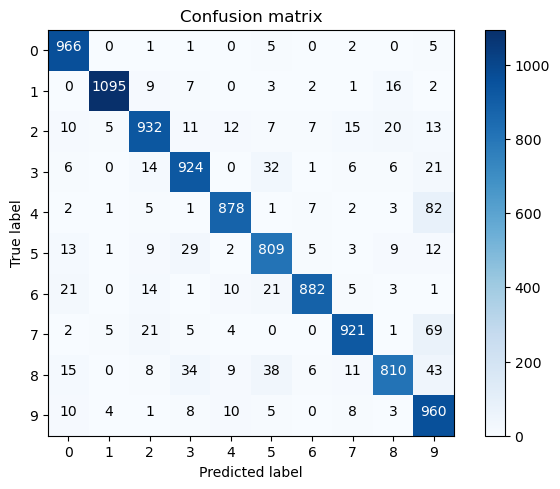

In [27]:
# Call method to plot confusion matrix
cm(y_true, y_pred)